In [1]:
from torchvision import datasets
import numpy as np
import random
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from keras.models import model_from_json
from augment import *
import sample_data
from utils import *
import models

In [2]:
#select what image size you want, large size cannot be accomodate in system,
image_size=14 #have to be even

In [16]:
#downloading the dataset
# dataset_train = datasets.EMNIST('../data/cifar',split='digits', train=True, download = True, transform = basic(image_size))
# dataset_test = datasets.EMNIST('../data/cifar-t',split='digits',train=False, download = True, transform = basic(image_size))
dataset_train = datasets.CIFAR10('../data/cifar', train=True, download = True, transform = basic(image_size))
dataset_test = datasets.CIFAR10('../data/cifar-t',train=False, download = True, transform = basic(image_size))

Files already downloaded and verified
Files already downloaded and verified


In [17]:
#this is the image_size in(h,w,c) format that will be used 
image_shape=(image_size,image_size,dataset_train[0][0].shape[0])

User 	 Majority Class 

0 	 [4 5]
1 	 [9 0]
2 	 [3 7]
3 	 [9 5]
4 	 [4 8]


Number of Samples for Each user: 3332


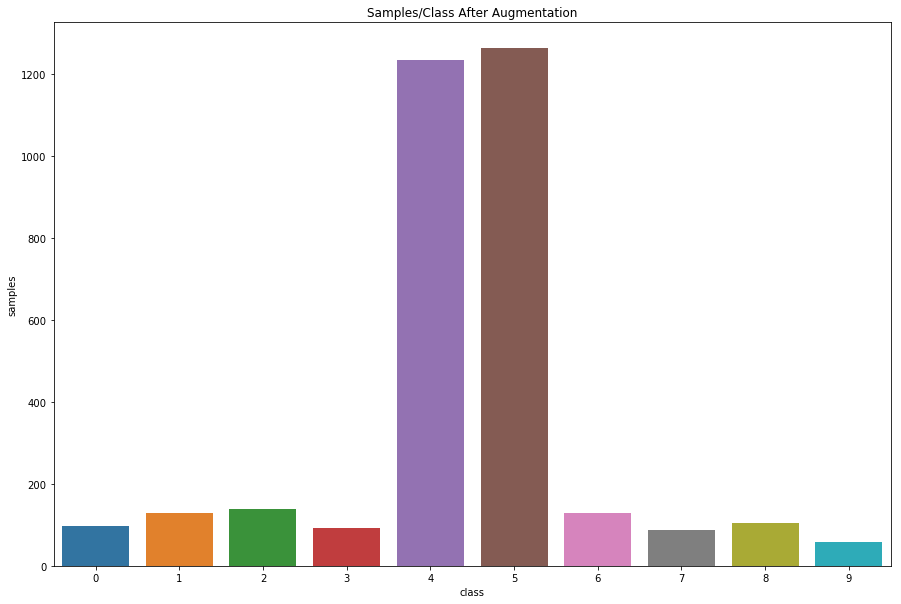

In [6]:
num_user=5  #select the num of users
p=0.7       #p is what percentage in each class, majority classs will cover the dataset(0.1-0.99)

#below line will sample the dataset and create the dicts for each user that will contain the index of images
#also prints the majority class that each user have
print('User \t Majority Class','\n')
dict_users,idx = sample_data.sampling(dataset_train,num_user,p)
print('\n')
#you can evaluate this cell as much you want untill you satisfied with the distribution
#it will help to create the barplot of count the number of images/class before augmentation
samples=[]
classes=[]
temp=list()
print('Number of Samples for Each user: '+str(len(dict_users[0])))
for i in dict_users[0]: 
    temp.append(dataset_train[i][1])
for i in range(10):
    classes.append(i) 
    samples.append(temp.count(i))

mydict={'class':classes,
        'samples':samples}

plt.figure(figsize=(15,10))
df=pd.DataFrame(mydict,columns=['class','samples'])
sns.barplot(y=df['samples'],x=df['class'],data=df)
plt.title('Samples/Class After Augmentation')
plt.show()


In [19]:
#converting tensors dataset to list for easy manipulation
dataset_train=list(dataset_train)

  0%|          | 0/5 [00:00<?, ?it/s]/users/ugrad/aggarwau/.local/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")
100%|██████████| 5/5 [00:06<00:00,  1.38s/it]

Added 5 Augemented Images/class for each user to dataset

Number of Samples for Each user after Augmentation: 8327


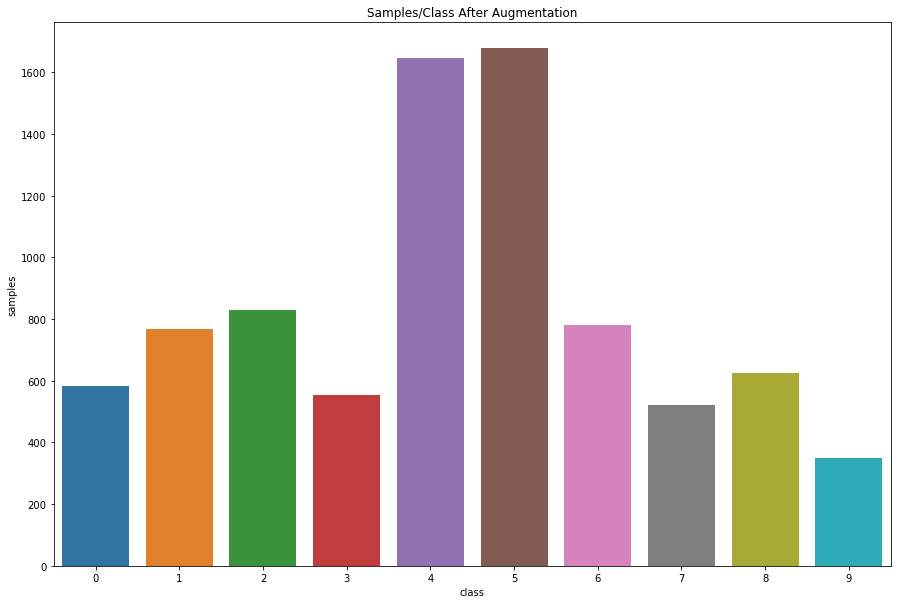

In [20]:
#Adding augmentated images to the dataset, specify the s value (s defines the number of aug image you want to add)

dict_users,dataset_train=normal_aug(dict_users,dataset_train,idx,num_user,s=5)

#Evaluate this cell to check the barplot of count the number of images/class after augmentation
samples=[]
classes=[]
temp=list()
print('\nNumber of Samples for Each user after Augmentation: '+str(len(dict_users[0])))
for i in dict_users[0]: 
    temp.append(dataset_train[i][1])
for i in range(10):
    classes.append(i) 
    samples.append(temp.count(i))

mydict={'class':classes,
        'samples':samples}

plt.figure(figsize=(15,10))
df=pd.DataFrame(mydict,columns=['class','samples'])
sns.barplot(y=df['samples'],x=df['class'],data=df)
plt.title('Samples/Class After Augmentation')
plt.show()


In [21]:
#converting image shape 'tensor(c,h,w)' --> numpy(h,w,c)' which is easy to train
for i in range(len(dataset_train)):
    temp=dataset_train[i][0]
    if(temp.shape!=image_shape):
        temp=np.transpose(temp.numpy())
    dataset_train[i]=[temp,dataset_train[i][1]]

In [22]:
dataset_train[56850][0].shape

(14, 14, 3)

In [23]:
#process and batch the training data for each client
clients_batched = dict()
lb=LabelBinarizer()
for (client_name, img_indxs) in dict_users.items():
    clients_batched[client_name] = batch_data(lb,img_indxs,dataset_train)

In [24]:
#creating 2 test set for validation
test_batched_1,test_batched_2=test_data(lb,dataset_test)

In [25]:
#deleting the datasets to free some memory.
del dataset_test
del dataset_train

In [26]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [14]:
#Evaluate this cell, if you wan tot train last updated global model instead of starting again
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# global_model = model_from_json(loaded_model_json)
# # load weights into new model
# global_model.load_weights("model.h5")
# print("Loaded model from disk") 

In [27]:
#initialize global model
smlp_global = models.SimpleMLP()
global_model = smlp_global.build(10,image_shape)

comm_round=40

#commence global training loop
for comm_round in range(comm_round):     
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()

    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()
#     pltCallBack = PlotLossAccuracy()
    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = models.SimpleMLP()
        local_model = smlp_local.build(10,image_shape)
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
      #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=10, verbose=0,validation_data=test_batched_1)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
       
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
    model_json = global_model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
# serialize weights to HDF5
    global_model.save_weights("model.h5")
    print("Saved model to disk")
    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched_2:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)

Saved model to disk
comm_round: 0 | global_acc: 16.200% | global_loss: 2.3019425868988037
Saved model to disk
comm_round: 1 | global_acc: 18.800% | global_loss: 2.2904582023620605
Saved model to disk
comm_round: 2 | global_acc: 25.640% | global_loss: 2.263974189758301
Saved model to disk
comm_round: 3 | global_acc: 27.020% | global_loss: 2.269014358520508
Saved model to disk
comm_round: 4 | global_acc: 30.200% | global_loss: 2.2492856979370117
Saved model to disk
comm_round: 5 | global_acc: 32.080% | global_loss: 2.2465360164642334
Saved model to disk
comm_round: 6 | global_acc: 33.840% | global_loss: 2.221561908721924
Saved model to disk
comm_round: 7 | global_acc: 34.660% | global_loss: 2.227628231048584
Saved model to disk
comm_round: 8 | global_acc: 37.160% | global_loss: 2.195589065551758
Saved model to disk
comm_round: 9 | global_acc: 37.340% | global_loss: 2.209622859954834
Saved model to disk
comm_round: 10 | global_acc: 38.980% | global_loss: 2.164522886276245
Saved model to d